In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import confusion_matrix, classification_report, \
    PrecisionRecallDisplay, RocCurveDisplay, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, AlphaDropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

In [2]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def plot_scatter(X: 'reduced dataset', y: 'target variable',
                 class_names: dict = None, figsize = (6, 4), ax = None,
                 top_legend = True):
    '''
    class_names: dict mapping class numbers (y) to class names
    '''
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    scatter = ax.scatter(X[:, 0], X[:, 1], c = y, edgecolor = 'k', lw = 0.5)
    handles, labels = scatter.legend_elements()
    if class_names is not None:
        # each item in labels has the format '$\\mathdefault{number}$'
        keys = [int(''.join(filter(str.isdigit, string))) for string in labels]
        labels = [class_names[i] for i in keys]
    ax.set_xlabel('1st Component', fontsize = 14)
    ax.set_ylabel('2nd Component', fontsize = 14)
    ax.set_xticks([])
    ax.set_yticks([])
    if top_legend:
        ax.legend(handles, labels, loc = 'lower center', ncol = 2,
                  fontsize = 'small', bbox_to_anchor = (0, 1, 1, 1))
    else:
        ax.legend(handles, labels, fontsize = 'small',
                  loc = 'center left',  bbox_to_anchor = (1.04, 0.5), borderaxespad = 0)

In [4]:
def report(results, n_top=3):
    df = pd.DataFrame()
    rank_names = []
    score_names = []
    for measure, values in results.items():
        if 'rank' == measure[:4]:
            rank_names.append(measure)
            score_name = measure[5:]
            score_names.append(score_name)
            df[measure] = values
    for score_name in score_names:
        df['mean_'+score_name] = results['mean_'+score_name]
        df['std_'+score_name] = results['std_'+score_name]
    df = pd.concat((df, pd.DataFrame(results['params'])), axis=1)
    df.sort_values(by=rank_names, inplace=True)
    df.index.name = 'model_idx'
    return df.head(n_top)

In [5]:
def plot_score(report:'cv_results_', score_name='score',
               legend_name=None, ax=None):
    if legend_name is None:
        legend_name = score_name
    if ax is None:
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot()

    # test score
    mean_val_score = report['mean_test_'+score_name]
    std_val_score = report['std_test_'+score_name]
    n = len(mean_val_score)
    x = range(n)
    ax.plot(x, mean_val_score, label='Validation set '+legend_name)
    ax.fill_between(x, mean_val_score - std_val_score,
                     mean_val_score + std_val_score, alpha = 0.2)

    # train score
    if 'mean_train_'+score_name in report:
        mean_train_score = report['mean_train_'+score_name]
        std_train_score = report['std_train_'+score_name]
        ax.plot(x, mean_train_score, label='Train set '+legend_name)
        ax.fill_between(x, mean_train_score - std_train_score,
                        mean_train_score + std_train_score,
                        alpha=0.2)
    return ax

In [6]:
def plot_confusion_mtx(cm: 'confusion matrix', labels = None,
                       figsize = (3,3), binary = False, ax=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
    sns.heatmap(cm, annot = True, fmt = '0', annot_kws = {"fontsize": 16},
                cmap = "Blues", cbar = False, ax = ax)
    ax.set_xlabel('Predicted Class', fontsize = 14)
    ax.set_ylabel('Actual Class', fontsize = 14)
    if labels is None:
        labels = range(1, cm.shape[1] + 1)
    ax.set_xticks(ax.get_xticks(), labels)
    ax.set_yticks(ax.get_yticks(), labels)
    if binary:
        ax.set_xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.set_yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
    return ax

In [7]:
def plot_multiclass_roc(clf, X, y, clf_name='', ax=None):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        RocCurveDisplay.from_predictions(class_i_arr, class_i_prob_arr,
                        name = clf_name + f'class {label}', ax = ax)
    random = ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'k--',
                 label = 'Random Classifier')
    ax.set_ylabel('True Positive Rate', fontsize = 14)
    ax.set_xlabel('False Positive Rate', fontsize = 14)
    return ax

In [8]:
def plot_multiclass_lift(clf, X, y, clf_name='', ax=None,
                          baseline = False):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)
    n_samples = X.shape[0]
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        idx = np.argsort(class_i_prob_arr)[::-1]
        acc = np.cumsum(class_i_arr[idx])
        perc_trues = acc / acc[-1]
        cum_samples = np.arange(1, n_samples + 1)
        perc_samples = cum_samples / n_samples
        lift = perc_trues / perc_samples
        ax.plot(lift, label = f'class {label}')
    if baseline:
        plt.axhline(y = 1, ls = '--', color = 'k')
    xticks = np.linspace(0, n_samples, 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1)
    ax.set_xticks(xticks, x_lab)
    ax.set_xlabel('% of samples', fontsize = 14)
    ax.set_ylabel('Cumulative', fontsize = 14)
    return ax

In [9]:
def plot_multiclass_gain(clf, X, y, clf_name='', ax=None,
                          baseline = False):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)
    n_samples = X.shape[0]
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        idx = np.argsort(class_i_prob_arr)[::-1]
        acc = np.cumsum(class_i_arr[idx])
        ax.plot(acc, label = f'class {label}')
        if baseline:
            plt.plot([0,n_samples], [0, acc[-1]], 'k--', lw=0.75,alpha=1.)
    xticks = np.linspace(0, n_samples, 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1)
    ax.set_xticks(xticks, x_lab)
    ax.set_xlabel('% of samples', fontsize = 14)
    ax.set_ylabel('Cumulative', fontsize = 14)
    return ax

In [10]:
def plot_multiclass_prec_rec(clf, X, y, clf_name='', ax=None):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        PrecisionRecallDisplay.from_predictions(class_i_arr, class_i_prob_arr,
                        name = clf_name + f'class {label}', ax = ax),
        ax.axhline(y = (class_i_arr.sum() / y.size), ls = '--', lw=0.75, alpha=1.,
                        color = 'k')
    ax.set_ylabel('Precision', fontsize = 14)
    ax.set_xlabel('Recall', fontsize = 14)
    return ax

In [12]:

X_train = pd.read_csv('X_train_no_red.csv', header = 0)
y_train = pd.read_fwf('y_train.txt', header = None)
X_test = pd.read_csv('X_test_no_red.csv', header = 0)
y_test = pd.read_fwf('y_test.txt', header = None)

In [13]:
X_train.columns = X_train.columns.astype(int)
X_test.columns = X_test.columns.astype(int)

In [14]:
with open("features.txt") as f:
    lines = f.read().splitlines()

In [15]:
features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name

In [16]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

##MULTILAYER PERCEPTRON

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

k_fold = StratifiedKFold(n_splits=4)


# Definizione dei parametri da testare
parameters = {
    'hidden_layer_sizes': [(12, 23, 11), (23, 43, 32), (128, 64, 32)],
    'activation': ['logistic', 'relu'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'tol': [1e-2, 1e-3, 1e-4],
    #'alpha': 10.0 ** -np.arange(1, 7),
    'solver': ['sdg', 'adam']
    'early_stopping': [True, False]
}

# Creazione dell'oggetto della rete neurale
neural_net = MLPClassifier()

# Creazione dell'oggetto GridSearchCV
grid_search = GridSearchCV(neural_net, parameters, cv=5)

# Addestramento della rete neurale con la grid search
grid_search.fit(X_train, y_train)

# Stampare i risultati
print("Best parameters set found on development set:")
print()
print(grid_search.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Valutazione finale del modello
print("Best score achieved: %0.3f" % grid_search.best_score_)
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, grid_search.predict(X_test)


In [ ]:
y_score = clf.predict_proba(X_test)

In [19]:
clf = MLPClassifier(solver = 'adam', momentum = 0.9, learning_rate = 'adaptive' , hidden_layer_sizes=(128, 64, 32),early_stopping= False, activation= "relu")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
print(classification_report(y_test, y_pred, target_names=activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.95      0.97      0.96       496
  WALKING_UPSTAIRS       0.94      0.95      0.94       471
WALKING_DOWNSTAIRS       0.97      0.95      0.96       420
           SITTING       0.97      0.86      0.91       491
          STANDING       0.86      0.98      0.92       532
            LAYING       1.00      0.97      0.99       537

          accuracy                           0.95      2947
         macro avg       0.95      0.94      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

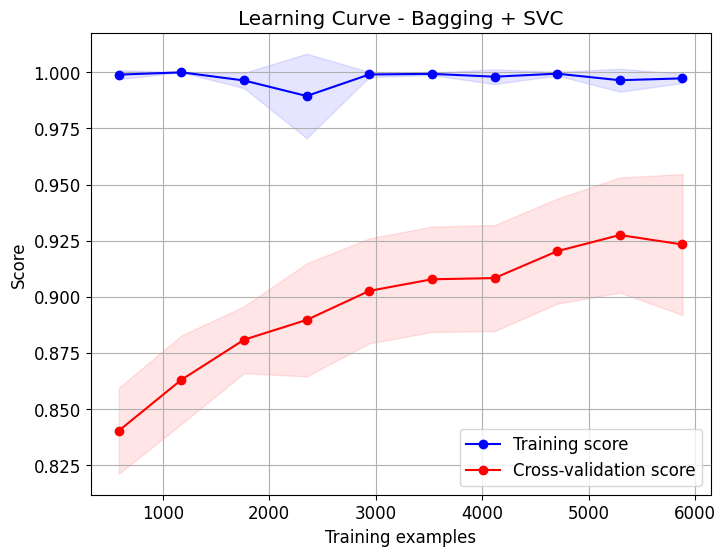

In [23]:
from sklearn.model_selection import learning_curve
# Calcola la learning curve
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcola le medie e gli errori standard delle prestazioni
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotta la learning curve
plt.figure(figsize=(8, 6))
plt.title('Learning Curve - Multilayer Perceptron')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid(True)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='b')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color='r')
plt.plot(train_sizes, train_scores_mean, 'o-', color='b',
         label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
         label='Cross-validation score')
plt.legend(loc='best')
plt.show()

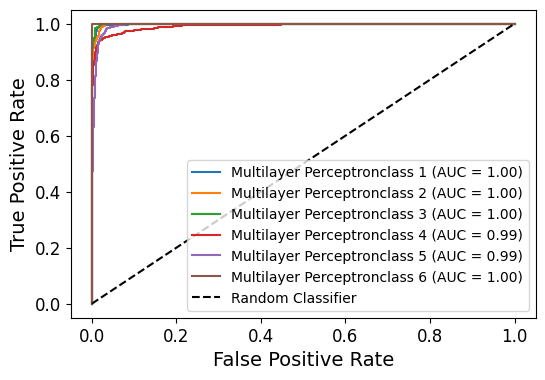

In [24]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
plot_multiclass_roc(clf, X_test, y_test,
                    'Multilayer Perceptron', ax = ax)
ax.legend(fontsize = 'small')
#plt.savefig('RF_multiclass_roc.pdf', bbox_inches = 'tight')
plt.show()

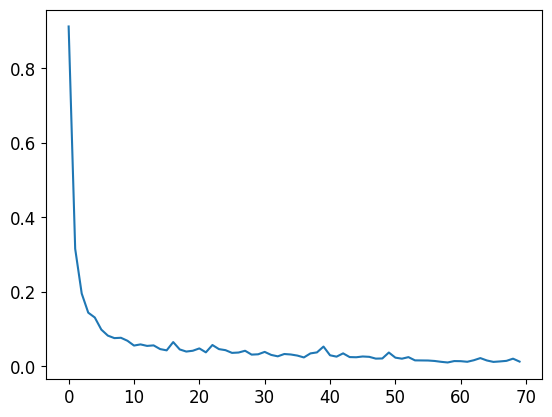

In [25]:
plt.plot(clf.loss_curve_)
plt.show()